In [1]:
from llm_manager import get_llm_instance
from typing import TypedDict, Literal
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END
import re, json

F:\GenAI\LangGraph_OpenSource\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. LLM

In [2]:
llm = get_llm_instance()

Initializing LLM: mistralai/Mistral-7B-Instruct-v0.2...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
Device set to use cuda


LLM initialization complete for mistralai/Mistral-7B-Instruct-v0.2.


F:\GenAI\LangGraph_OpenSource\llm_manager.py:29: UserWarning: LLMManager is already initialized. Returning existing instance.
  warnings.warn("LLMManager is already initialized. Returning existing instance.")


# 2. Output Parser

In [3]:
output_parser = StrOutputParser()

# 3. Define State

In [4]:
class ReviewState(TypedDict):
    text: str
    sentiment: Literal['positive','negative']
    
    diagnosis: dict
    response: str

# Utility Functions

In [5]:
def extract_json(llm_output: str) -> str:
    # Expect a string, not a dict
    matches = re.findall(r"\{[^{}]*\}", llm_output)
    if not matches:
        return ""
    try:
        parsed_json = json.loads(matches[-1])
        return parsed_json
    except Exception as e:
        print("JSON parse failed:", e)
        return ""

# 4. Node Define

In [6]:
def find_sentiment(state: ReviewState):
    text = state['text']
    
    prompt = PromptTemplate(
        template = """
        You are an assistant that always responds ONLY with valid JSON.
        
        Task:
        Extract the sentiment of the following statement as either "positive" or "negative".
        
        Required format:
        {{
          "sentiment": "positive or negative"
        }}
        
        Statement:
        "{text}"
        """,input_variables=['text']
    )
    chain = prompt | llm | output_parser

    response = chain.invoke({"text": text})
    
    response = extract_json(response)
    
    sentiment = response['sentiment'].lower().strip()
    
    allowed = {"positive", "negative"}
    if sentiment not in allowed:
        sentiment = "negative"  

    return {"sentiment": sentiment}

In [7]:
def sentiment_routing(state: ReviewState) -> Literal['positive_response','need_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'need_diagnosis'

In [8]:
def positive_response(state: ReviewState):
    text = state['text']
    
    prompt = PromptTemplate(
        template="""
        Write a warm thank-you message in response to this review:
        \n\n\ "{text}" \n
        Also, kindly ask the user to leave feedback on our website.
        """,input_variables=['text']
    )
    
    chain = prompt | llm | output_parser
    
    response = chain.invoke({"text": text})
    return {"response": response}   

<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Jehan\AppData\Local\Temp\ipykernel_4404\2186648233.py:5: SyntaxWarning: invalid escape sequence '\ '
  template="""


In [9]:
def need_diagnosis(state: ReviewState):
    text = state['text']
    prompt = PromptTemplate(template="""
    You are an assistant that always responds ONLY with valid JSON, no extra text.
        
        Task:  
        Analyze the following customer review and extract exactly three fields:  
        1. "issue_type" → The category of issue mentioned in the review.  
           Must be one of: "UX", "Performance", "Bug", "Support", "Other".  
           - "UX" if it’s about usability, navigation, or user interface issues.  
           - "Performance" if it’s about speed, lag, crashes, or memory usage.  
           - "Bug" if it’s about errors, glitches, incorrect behavior, or broken features.  
           - "Support" if it’s about customer service, help, or lack of assistance.  
           - "Other" if it does not fit any of the above.  
        
        2. "tone" → The emotional tone expressed by the user.  
           Must be one of: "angry", "frustrated", "disappointed", "calm".  
           - "angry" = very upset, hostile, strong negative emotion.  
           - "frustrated" = annoyed, irritated, complaining, but less hostile.  
           - "disappointed" = expressing sadness or letdown without aggression.  
           - "calm" = neutral or constructive, no visible anger or frustration.  
        
        3. "urgency" → How critical or time-sensitive the issue appears to be.  
           Must be one of: "low", "medium", "high".  
           - "low" = minor issue, no immediate fix required.  
           - "medium" = notable problem, needs attention soon.  
           - "high" = severe issue, strongly impacts user experience or requires urgent action.  
        
        Required output format (strict JSON, no comments, no explanations, no additional text):  
        {{
          "issue_type": "UX" | "Performance" | "Bug" | "Support" | "Other",
          "tone": "angry" | "frustrated" | "disappointed" | "calm",
          "urgency": "low" | "medium" | "high"
        }}
        
        Review to analyze:  
        "{text}"
    """,input_variables=['text']
    )
    
    chain = prompt | llm | output_parser
    
    diagnosis = chain.invoke({"text": text})
    
    diagnosis = extract_json(diagnosis)
    
    return {"diagnosis": diagnosis}

In [13]:
def negative_response(state: ReviewState):
    issue_type = state['diagnosis']['issue_type']
    tone = state['diagnosis']['tone']
    urgency = state['diagnosis']['urgency']
    
    print('issue_type',issue_type)
    print('tone',tone)
    print('urgency',urgency)
    
    prompt = PromptTemplate(
        template="""   # ✅ FIXED
        You are a support assistant.
        The user had a '{issue_type}' issue, sounded '{tone}', and marked urgency as '{urgency}'.
        Write an empathetic, helpful resolution message.
        """,
        input_variables=['issue_type','tone','urgency']
    )
    
    chain = prompt | llm | output_parser
    
    response = chain.invoke({
        "issue_type": issue_type,
        "tone": tone,
        "urgency": urgency
    })
    
    print("-----------------------------------")
    print(response)
    print("-----------------------------------")
    return {"response": response} 


# 5. Graph Design

<unknown>:5: SyntaxWarning: invalid escape sequence '\ '


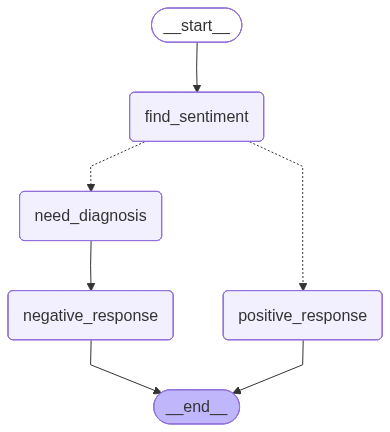

In [14]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('need_diagnosis',need_diagnosis)
graph.add_node('negative_response',negative_response)
graph.add_node('positive_response',positive_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', sentiment_routing)

graph.add_edge('need_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

graph.add_edge('positive_response', END)

workflow = graph.compile()
workflow

# 6. Execute

In [15]:
initial_state = {'text' : "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."}

final_state = workflow.invoke(initial_state)
print(final_state)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


issue_type Performance
tone angry
urgency high
-----------------------------------
<s> [INST]    # ✅ FIXED
        You are a support assistant.
        The user had a 'Performance' issue, sounded 'angry', and marked urgency as 'high'.
        Write an empathetic, helpful resolution message.
         [/INST] I'm really sorry to hear that you're experiencing a performance issue with our product and I can understand how frustrating that must be, especially given the urgency of your concern. I want to assure you that we take these matters seriously and I'm here to help in any way I can.

To begin with, I'd like to gather some more information about the issue you're encountering. Could you please provide some details such as the specific symptoms you're experiencing, the type of device or browser you're using, and any error messages you've encountered? This information will help me better understand the issue and provide a more effective resolution.

In the meantime, I'd recommend trying so

In [16]:
final_state['sentiment']

'negative'

In [17]:
final_state['diagnosis']

{'issue_type': 'Performance', 'tone': 'angry', 'urgency': 'high'}

In [18]:
final_state['response']

"<s> [INST]    # ✅ FIXED\n        You are a support assistant.\n        The user had a 'Performance' issue, sounded 'angry', and marked urgency as 'high'.\n        Write an empathetic, helpful resolution message.\n         [/INST] I'm really sorry to hear that you're experiencing a performance issue with our product and I can understand how frustrating that must be, especially given the urgency of your concern. I want to assure you that we take these matters seriously and I'm here to help in any way I can.\n\nTo begin with, I'd like to gather some more information about the issue you're encountering. Could you please provide some details such as the specific symptoms you're experiencing, the type of device or browser you're using, and any error messages you've encountered? This information will help me better understand the issue and provide a more effective resolution.\n\nIn the meantime, I'd recommend trying some general troubleshooting steps to see if they help improve the performan